# Install requirements

In [1]:
%pip install -q python-dotenv langchain langchain_core langchain-community langchain-chroma ipywidgets umap-learn pandas chromadb openai langchain-openai yt-dlp assemblyai matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# Import packages

In [2]:
import sys
import subprocess
import chromadb
import openai
import langchain_openai
import yt_dlp
import assemblyai
import dotenv
import pandas
import matplotlib
import seaborn
import os
import sys
import json
import time
import uuid
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown, clear_output
import chromadb
from chromadb.utils import embedding_functions

# Configure Visualization (Optional)

In [3]:
# Configure visualization
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load configuration

In [4]:
# Load pipeline configuration
config_path = os.path.join(os.getcwd(), 'pipeline_config.json')
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
    print("Loaded pipeline configuration")
else:
    print("Warning: pipeline_config.json not found, using defaults")
    config = {}

print(config.get('messages', {}).get('import_complete', 'Imports complete'))

Loaded pipeline configuration
Imports complete


## Load environment variables

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()  # loads .env if present

required = ('YOUTUBE_API_KEY', 'ASSEMBLYAI_API_KEY', 'OPENAI_API_KEY')
missing  = [var for var in required if not os.getenv(var)]

if missing:
    print(f"Missing env vars: {', '.join(missing)}")

## Create local data storage (JSON)

In [6]:
import os, json

DATA_DIR = os.path.join(os.getcwd(), config.get('data_directory', '.'))
os.makedirs(DATA_DIR, exist_ok=True)

json_files = {
    k: os.path.join(DATA_DIR, fname)
    for k, fname in config.get('data_files', {}).items()
}

for path in json_files.values():
    if not os.path.exists(path):
        with open(path, 'w') as f:
            json.dump([], f)

## Initialize ChromaDB

In [7]:
print("Initializing ChromaDB...")

# Create ChromaDB directory
CHROMA_DIR = os.path.join(DATA_DIR, 'chromadb')
os.makedirs(CHROMA_DIR, exist_ok=True)

# Initialize ChromaDB client with persistent storage
chroma_client = chromadb.PersistentClient(path=CHROMA_DIR)

# Create embedding function using OpenAI
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.getenv('OPENAI_API_KEY'),
    model_name=config.get('semantic_search', {}).get('embedding_model', os.getenv('EMBEDDING_MODEL', 'text-embedding-3-small'))
)

# Create or get collections for segments and insights
try:
    segments_collection = chroma_client.get_or_create_collection(
        name="segments",
        embedding_function=openai_ef,
        metadata={"description": "Episode transcript segments"}
    )
    
    insights_collection = chroma_client.get_or_create_collection(
        name="insights",
        embedding_function=openai_ef,
        metadata={"description": "Extracted episode insights"}
    )
    
    print(f"ChromaDB initialized successfully!")
    print(f"  - Segments collection: {segments_collection.count()} items")
    print(f"  - Insights collection: {insights_collection.count()} items")
    
except Exception as e:
    print(f"Error initializing ChromaDB: {e}")
    segments_collection = None
    insights_collection = None

Initializing ChromaDB...
ChromaDB initialized successfully!
  - Segments collection: 0 items
  - Insights collection: 0 items


# Step 1: Audio Download

## Download audio

In [8]:

import yt_dlp

# Configuration
YOUTUBE_URL = os.getenv('YOUTUBE_URL')

# Extract video ID
video_id = YOUTUBE_URL.split('v=')[-1].split('&')[0]
audio_dir = os.path.join(os.getcwd(), config.get('audio_directory', 'audio_storage'))
os.makedirs(audio_dir, exist_ok=True)

# Check if episode exists
with open(json_files['episodes'], 'r') as f:
    episodes_data = json.load(f)
existing = [ep for ep in episodes_data if ep['youtube_video_id'] == video_id]

# Always download, regardless of whether episode exists
print(f"{config.get('messages', {}).get('downloading_audio', 'Downloading audio from:')} {YOUTUBE_URL}")

# Download with yt-dlp
output_path = os.path.join(audio_dir, f'{video_id}.mp3')

ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
    'outtmpl': output_path.replace('.mp3', '.%(ext)s'),
    'quiet': True,
    'no_warnings': True,
}

try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(YOUTUBE_URL, download=True)
        
    # Create episode record
    episode_id = str(uuid.uuid4())
    episode_data = {
        'id': episode_id,
        'title': info.get('title', 'Unknown Title'),
        'youtube_video_id': video_id,
        'youtube_url': YOUTUBE_URL,
        'duration': info.get('duration', 0),
        'published_at': datetime.now().isoformat(),
        'status': 'downloaded',
        'audio_file_path': output_path,
        'summary': '',
        'is_processed': False
    }
    
    # Save to JSON
    episodes_data.append(episode_data)
    with open(json_files['episodes'], 'w') as f:
        json.dump(episodes_data, f, indent=2)
    
    print(f"Downloaded: {episode_data['title']}")
except Exception as e:
    print(f"Download error: {e}")
    episode_id = None

Downloaded: The Build - LangChain Open Deep Research       


## Display episode info

In [9]:
if episode_id:                      
    print(
        f"Episode Info:\n"
        f"  Title: {episode_data['title']}\n"
        f"  YouTube ID: {video_id}\n"
        f"  Duration: {episode_data['duration']} s\n"
        f"  Status: {episode_data['status']}"
    )
else:
    print("Failed to download or load episode")

Episode Info:
  Title: The Build - LangChain Open Deep Research
  YouTube ID: Y0KB8FsbCKc
  Duration: 1608 s
  Status: downloaded


# Step 2: Transcription

In [10]:
import os, json, uuid, assemblyai as aai

if not episode_id:                               # ensure download step ran
    raise RuntimeError("episode_id missing")

with open(json_files['segments']) as f:          # load existing segments
    all_segments = json.load(f)

segments = [s for s in all_segments if s['episode_id'] == episode_id]

if not segments:                                 # need to transcribe
    aai.settings.api_key = os.getenv('ASSEMBLYAI_API_KEY')
    tr = aai.Transcriber().transcribe(
        episode_data['audio_file_path'],
        config=aai.TranscriptionConfig(speaker_labels=True, speakers_expected=2),
    )
    if tr.status == aai.TranscriptStatus.error:
        raise RuntimeError(f"AssemblyAI: {tr.error}")

    segments = [
        {
            'id': str(uuid.uuid4()),
            'episode_id': episode_id,
            'start_time': u.start / 1000,
            'end_time':  u.end   / 1000,
            'raw_text':  u.text,
            'display_text': u.text,
            'speaker': f"Speaker {u.speaker}",
            'confidence': getattr(u, 'confidence', 0.9),
            'duration': (u.end - u.start) / 1000,
        }
        for u in tr.utterances
    ]
    all_segments.extend(segments)
    with open(json_files['segments'], 'w') as f:
        json.dump(all_segments, f, indent=2)

    print("Transcription completed.")

Transcription completed.


# Extract insights

In [11]:
import os, json, uuid, traceback
from openai import OpenAI
import assemblyai as aai   # if still needed elsewhere

if not episode_id or not segments:
    raise RuntimeError("Missing episode_id or segments—run previous steps first.")

SEGMENT_COUNT = len(segments)
INSIGHT_BATCH = config.get('processing', {}).get('transcript_batch_size', 10)
MAX_BATCHES   = config.get('processing', {}).get('max_transcript_batches', 10)

client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

with open(json_files['insights']) as f:
    all_insights = json.load(f)

new_insights = []

for i in range(0, min(SEGMENT_COUNT, INSIGHT_BATCH * MAX_BATCHES), INSIGHT_BATCH):
    batch = segments[i : i + INSIGHT_BATCH]
    transcript = "\n".join(f"{s['speaker']}: {s['display_text']}" for s in batch)[:3500]

    try:
        resp = client.chat.completions.create(
            model=os.getenv('LLM_MODEL'),
            messages=[
                {"role": "system", "content": config.get('llm_prompts', {}).get('insight_extraction', '')},
                {"role": "user",   "content": f"Extract insights from this podcast segment:\n\n{transcript}"}
            ],
            temperature=0.1
        )
        batch_data = json.loads(resp.choices[0].message.content).get('insights', [])
        for ins in batch_data:
            if ins.get('content'):
                new_insights.append({
                    'id': str(uuid.uuid4()),
                    'episode_id': episode_id,
                    'category': ins.get('category', 'Business Ideas'),
                    'content': ins['content'],
                    'confidence_score': float(ins.get('confidence', 0.8)),
                    'segment_start': batch[0]['start_time'],
                    'segment_end':   batch[-1]['end_time'],
                })
    except Exception:          # JSON errors, API errors, etc.
        traceback.print_exc()   # optional: comment out to silence

# save if any new insights
if new_insights:
    all_insights.extend(new_insights)
    with open(json_files['insights'], 'w') as f:
        json.dump(all_insights, f, indent=2)

print(f"Segments: {SEGMENT_COUNT}")
print(f"Total insights extracted: {len(new_insights)}")
print(f"Success: saved {len(new_insights)} insights to JSON.")

Traceback (most recent call last):
  File "/var/folders/jg/_69v8t_d6k94phbfc_2y962w0000gn/T/ipykernel_2628/780309293.py", line 24, in <module>
    resp = client.chat.completions.create(
        model=os.getenv('LLM_MODEL'),
    ...<4 lines>...
        temperature=0.1
    )
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/_utils/_utils.py", line 287, in wrapper
    return func(*args, **kwargs)
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/resources/chat/completions/completions.py", line 1087, in create
    return self._post(
           ~~~~~~~~~~^
        "/chat/completions",
        ^^^^^^^^^^^^^^^^^^^^
    ...<43 lines>...
        stream_cls=Stream[ChatCompletionChunk],
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/_base_client.py", line 1256, in post
    return cast(ResponseT, self.request(cast_to,

Segments: 90
Total insights extracted: 0
Success: saved 0 insights to JSON.


Traceback (most recent call last):
  File "/var/folders/jg/_69v8t_d6k94phbfc_2y962w0000gn/T/ipykernel_2628/780309293.py", line 24, in <module>
    resp = client.chat.completions.create(
        model=os.getenv('LLM_MODEL'),
    ...<4 lines>...
        temperature=0.1
    )
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/_utils/_utils.py", line 287, in wrapper
    return func(*args, **kwargs)
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/resources/chat/completions/completions.py", line 1087, in create
    return self._post(
           ~~~~~~~~~~^
        "/chat/completions",
        ^^^^^^^^^^^^^^^^^^^^
    ...<43 lines>...
        stream_cls=Stream[ChatCompletionChunk],
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/openai/_base_client.py", line 1256, in post
    return cast(ResponseT, self.request(cast_to,

# Display insights

In [12]:

if 'insights' in locals() and insights:
    display_insights = insights
    
    display(Markdown("### Extracted Insights"))
    
    # Group by category
    df_insights = pd.DataFrame(display_insights)
    categories = df_insights['category'].value_counts()
    
    print(f"\nInsights by category:")
    for category, count in categories.items():
        print(f"   {category}: {count}")
    
    # Display insights by category
    for category, count in categories.items():
        display(HTML(f"<h4>{category} ({count})</h4>"))
        
        cat_insights = df_insights[df_insights['category'] == category].head(3)
        for _, insight in cat_insights.iterrows():
            display(HTML(f"""
            <div style='background: #f5f5f5; padding: 10px; margin: 5px 0; 
                        border-left: 3px solid #2196F3; border-radius: 5px;'>
                <p style='margin: 0;'>{insight['content']}</p>
                <small style='color: #666;'>Confidence: {insight['confidence_score']:.2f}</small>
            </div>
            """))
    
    # Visualize distribution
    if not categories.empty:
        plt.figure(figsize=(10, 5))
        categories.plot(kind='bar')
        plt.title('Insight Distribution by Category')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("\nNo insights to display. Check the debug output above.")


No insights to display. Check the debug output above.


# Step 3: Generate Summary

In [13]:
# Extract products mentioned
print(config.get('messages', {}).get('extracting_products', 'Extracting products from episode content...'))

# Check if we have data to work with
has_insights = 'insights' in locals() and insights
has_segments = 'segments' in locals() and segments

if not has_segments:
    print("Error: No segments available. Please run transcription first.")
else:
    # Read existing products
    with open(json_files['products'], 'r') as f:
        products_data = json.load(f)
    products_found = []
    
    # Get known products from config
    known_products = config.get('known_products', [])
    
    print(f"Searching for {len(known_products)} known products...")
    
    # Extract from insights if available
    if has_insights:
        print("\nChecking insights for product mentions...")
        for insight in insights:
            content = insight['content'].lower()
            
            for product in known_products:
                if product.lower() in content:
                    products_found.append({
                        'name': product,
                        'episode_id': episode_id,
                        'mentioned_in': 'insight',
                        'context': insight['content'][:200]
                    })
    
    # Extract from transcript segments
    demo_limit = config.get('processing', {}).get('demo_segment_limit', 50)
    print(f"\nChecking {min(len(segments), demo_limit)} transcript segments...")
    for i, segment in enumerate(segments[:demo_limit]):
        content = segment['display_text'].lower()
        
        for product in known_products:
            if product.lower() in content:
                products_found.append({
                    'name': product,
                    'episode_id': episode_id,
                    'mentioned_in': 'transcript',
                    'context': segment['display_text'][:200]
                })
    
    print(f"\nFound {len(products_found)} total product mentions")
    
    # Deduplicate and count mentions
    product_counts = {}
    for p in products_found:
        name = p['name']
        if name not in product_counts:
            product_counts[name] = {
                'count': 0,
                'episode_ids': [],
                'contexts': []
            }
        product_counts[name]['count'] += 1
        if episode_id not in product_counts[name]['episode_ids']:
            product_counts[name]['episode_ids'].append(episode_id)
        product_counts[name]['contexts'].append(p['context'])
    
    print(f"{len(product_counts)} unique products found")
    
    # Update products data
    new_products = []
    updated_count = 0
    
    for name, data in product_counts.items():
        # Check if product already exists
        existing = next((p for p in products_data if p['name'] == name), None)
        
        if not existing:
            # New product
            new_products.append({
                'id': str(uuid.uuid4()),
                'name': name,
                'episode_ids': data['episode_ids'],
                'mention_count': data['count']
            })
        else:
            # Update existing product
            if episode_id not in existing['episode_ids']:
                existing['episode_ids'].append(episode_id)
            existing['mention_count'] += data['count']
            updated_count += 1
    
    # Add new products
    if new_products:
        products_data.extend(new_products)
        print(f"Success: Added {len(new_products)} new products to database")
    
    if updated_count:
        print(f"Success: Updated {updated_count} existing products")
    
    # Save to JSON
    with open(json_files['products'], 'w') as f:
        json.dump(products_data, f, indent=2)
    
    print(f"\nSuccess: Products extraction complete!")
    print(f"   - Total unique products: {len(product_counts)}")
    print(f"   - Total mentions: {sum(p['count'] for p in product_counts.values())}")

Extracting products from episode content...
Searching for 501 known products...

Checking 90 transcript segments...

Found 76 total product mentions
24 unique products found
Success: Added 24 new products to database

Success: Products extraction complete!
   - Total unique products: 24
   - Total mentions: 76


# Display products

### Products Mentioned

#### Top Products by Mentions:

#### Product Mention Distribution:

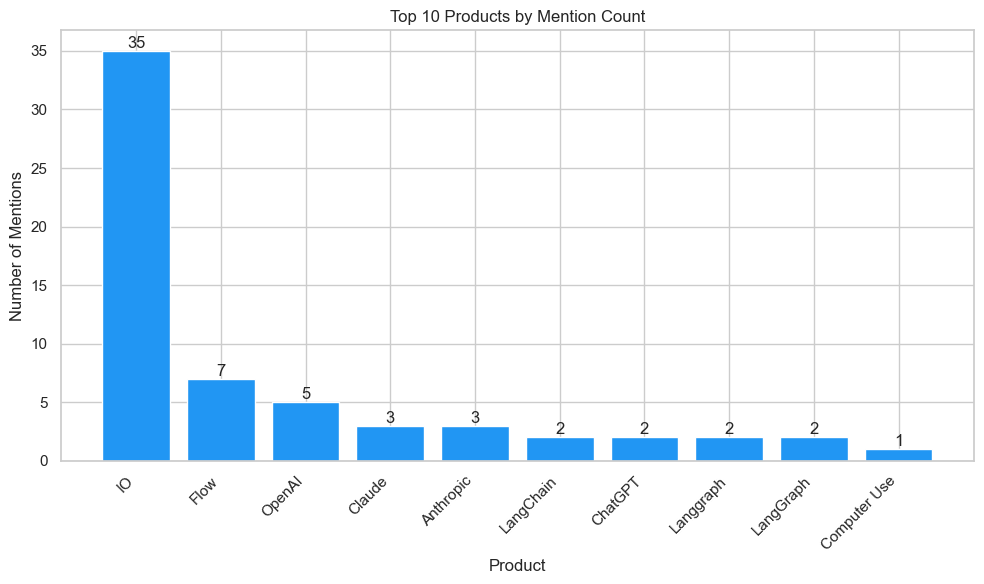

In [14]:

if product_counts:
    display(Markdown("### Products Mentioned"))
    
    # Sort by mention count
    sorted_products = sorted(product_counts.items(), key=lambda x: x[1]['count'], reverse=True)
    
    # Show top products with context
    display(Markdown("#### Top Products by Mentions:"))
    for i, (name, data) in enumerate(sorted_products[:10]):
        # Get a sample context
        sample_context = data['contexts'][0] if data['contexts'] else "No context available"
        
        display(HTML(f"""
        <div style='background: white; border: 1px solid #e0e0e0; border-radius: 8px; 
                    padding: 15px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <h5 style='margin: 0 0 10px 0; color: #333;'>
                {i+1}. {name} 
                <span style='background: #2196F3; color: white; padding: 2px 8px; 
                            border-radius: 12px; font-size: 12px; margin-left: 10px;'>
                    {data['count']} mentions
                </span>
            </h5>
            <p style='color: #666; font-size: 14px; margin: 0; font-style: italic;'>
                "{sample_context}..."
            </p>
        </div>
        """))
    
    # Product cloud visualization
    if len(sorted_products) > 5:
        display(Markdown("#### Product Mention Distribution:"))
        
        # Create bar chart
        top_10 = sorted_products[:10]
        names = [p[0] for p in top_10]
        counts = [p[1]['count'] for p in top_10]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(names, counts, color='#2196F3')
        plt.title('Top 10 Products by Mention Count')
        plt.xlabel('Product')
        plt.ylabel('Number of Mentions')
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
else:
    print("\nNo products found. This could be because:")
    print("   - The episode doesn't mention any known products")
    print("   - The transcript is too short")
    print("   - The product list needs to be expanded")

# Extract links, insights

In [15]:

import re

print(config.get('messages', {}).get('extracting_links', 'Extracting links from episode content...'))

if 'episode_id' not in locals():
    print("Error: Please run the Audio Download step first")
else:
    # Read existing links
    with open(json_files['links'], 'r') as f:
        links_data = json.load(f)
    found_links = []
    
    # Enhanced URL pattern to catch more URL formats
    url_patterns = [
        re.compile(r'https?://(?:www\.)?[^\s<>"{}|\\^`\[\]]+'),
        re.compile(r'(?:www\.)[^\s<>"{}|\\^`\[\]]+\.[a-z]{2,}'),
        re.compile(r'[a-zA-Z0-9-]+\.[a-z]{2,}/[^\s<>"{}|\\^`\[\]]*')
    ]
    
    print("Searching for links in available content...")
    
    # Extract from insights
    if 'insights' in locals() and insights:
        print(f"\nChecking {len(insights)} insights for links...")
        for insight in insights:
            for pattern in url_patterns:
                urls = pattern.findall(insight['content'])
                for url in urls:
                    # Normalize URL
                    if not url.startswith('http'):
                        url = 'https://' + url
                    found_links.append({
                        'url': url,
                        'source': 'insight',
                        'context': insight['content'][:150]
                    })
    
    # Extract from transcript
    if 'segments' in locals() and segments:
        print(f"\nChecking {min(len(segments), 30)} transcript segments for links...")
        for segment in segments[:30]:  # Check first 30 segments
            for pattern in url_patterns:
                urls = pattern.findall(segment['display_text'])
                for url in urls:
                    if not url.startswith('http'):
                        url = 'https://' + url
                    found_links.append({
                        'url': url,
                        'source': 'transcript',
                        'context': segment['display_text'][:150]
                    })
    
    # Get website mentions from config
    print("\nChecking for mentioned websites...")
    website_mentions = config.get('website_mentions', {})
    
    # Search in all available text
    all_text = ""
    if 'segments' in locals() and segments:
        all_text += " ".join([s['display_text'] for s in segments[:50]])
    if 'insights' in locals() and insights:
        all_text += " ".join([i['content'] for i in insights])
    
    all_text_lower = all_text.lower()
    
    for mention, url in website_mentions.items():
        if mention in all_text_lower:
            found_links.append({
                'url': url,
                'source': 'inferred',
                'context': f'{mention.title()} was mentioned in the episode'
            })
    
    print(f"\nFound {len(found_links)} total link mentions")
    
    # Deduplicate links
    unique_links = {}
    for link in found_links:
        url = link['url'].rstrip('/').lower()  # Normalize URL
        if url not in unique_links:
            unique_links[url] = link
    
    print(f"{len(unique_links)} unique links after deduplication")
    
    # Create link records
    new_links = []
    for url, link_data in unique_links.items():
        # Check if link already exists for this episode
        existing = next((l for l in links_data if l['episode_id'] == episode_id and l['url'] == link_data['url']), None)
        
        if not existing:
            # Extract title from URL
            url_parts = link_data['url'].replace('https://', '').replace('http://', '').split('/')
            domain = url_parts[0].replace('www.', '')
            title = domain.split('.')[0].title() if domain else 'Link'
            
            # Better title extraction
            if 'github.com' in link_data['url']:
                title = 'GitHub: ' + '/'.join(url_parts[1:3]) if len(url_parts) > 2 else 'GitHub'
            elif 'youtube.com' in link_data['url'] or 'youtu.be' in link_data['url']:
                title = 'YouTube Video'
            elif link_data['source'] == 'inferred':
                title = link_data['context']
            
            new_links.append({
                'id': str(uuid.uuid4()),
                'episode_id': episode_id,
                'url': link_data['url'],
                'title': title,
                'description': f"Found in {link_data['source']}: {link_data['context']}",
                'enriched': False
            })
    
    # Add new links
    if new_links:
        links_data.extend(new_links)
        with open(json_files['links'], 'w') as f:
            json.dump(links_data, f, indent=2)
        print(f"\nSuccess: Saved {len(new_links)} new links to JSON")
    else:
        print("\nNo new links found")

Extracting links from episode content...
Searching for links in available content...

Checking 30 transcript segments for links...

Checking for mentioned websites...

Found 3 total link mentions
3 unique links after deduplication

Success: Saved 3 new links to JSON


# Generate embeddings and store in ChromaDB

In [16]:

if episode_id and segments_collection and insights_collection:
    print(config.get('messages', {}).get('generating_embeddings', 'Generating vector embeddings and storing in ChromaDB...'))
    
    try:
        # Load segments and insights
        with open(json_files['segments'], 'r') as f:
            segments_data = json.load(f)
        with open(json_files['insights'], 'r') as f:
            insights_data = json.load(f)
        
        # Filter for current episode
        episode_segments = [s for s in segments_data if s['episode_id'] == episode_id]
        episode_insights = [i for i in insights_data if i['episode_id'] == episode_id]
        
        # Check existing embeddings in ChromaDB
        existing_segment_ids = []
        existing_insight_ids = []
        
        try:
            # Query for existing segments
            segment_results = segments_collection.get(
                where={"episode_id": episode_id}
            )
            existing_segment_ids = segment_results['ids'] if segment_results else []
            
            # Query for existing insights
            insight_results = insights_collection.get(
                where={"episode_id": episode_id}
            )
            existing_insight_ids = insight_results['ids'] if insight_results else []
        except:
            # Collections might be empty
            pass
        
        # Filter out already embedded items
        segments_to_embed = [s for s in episode_segments if s['id'] not in existing_segment_ids]
        insights_to_embed = [i for i in episode_insights if i['id'] not in existing_insight_ids]
        
        total_needed = len(segments_to_embed) + len(insights_to_embed)
        
        if total_needed > 0:
            print(f"Need to generate embeddings for:")
            if segments_to_embed:
                print(f"   - {len(segments_to_embed)} new segments")
            if insights_to_embed:
                print(f"   - {len(insights_to_embed)} new insights")
            
            # Add segments to ChromaDB
            if segments_to_embed:
                print("\nAdding segments to ChromaDB...")
                
                # Prepare data for ChromaDB
                segment_ids = [s['id'] for s in segments_to_embed]
                segment_texts = [s['display_text'] for s in segments_to_embed]
                segment_metadatas = [{
                    'episode_id': s['episode_id'],
                    'start_time': s['start_time'],
                    'end_time': s['end_time'],
                    'speaker': s['speaker'],
                    'duration': s['duration']
                } for s in segments_to_embed]
                
                # Add to ChromaDB in batches
                batch_size = config.get('semantic_search', {}).get('batch_size', 20)
                
                for i in range(0, len(segments_to_embed), batch_size):
                    batch_end = min(i + batch_size, len(segments_to_embed))
                    print(f"   Processing batch {i//batch_size + 1}/{(len(segments_to_embed)-1)//batch_size + 1}...")
                    
                    segments_collection.add(
                        documents=segment_texts[i:batch_end],
                        ids=segment_ids[i:batch_end],
                        metadatas=segment_metadatas[i:batch_end]
                    )
                
                print(f"Success: Added {len(segments_to_embed)} segments to ChromaDB")
            
            # Add insights to ChromaDB
            if insights_to_embed:
                print("\nAdding insights to ChromaDB...")
                
                # Prepare data for ChromaDB
                insight_ids = [i['id'] for i in insights_to_embed]
                insight_texts = [i['content'] for i in insights_to_embed]
                insight_metadatas = [{
                    'episode_id': i['episode_id'],
                    'category': i['category'],
                    'confidence_score': i['confidence_score'],
                    'segment_start': i['segment_start'],
                    'segment_end': i['segment_end']
                } for i in insights_to_embed]
                
                # Add all insights at once (usually fewer than segments)
                insights_collection.add(
                    documents=insight_texts,
                    ids=insight_ids,
                    metadatas=insight_metadatas
                )
                
                print(f"Success: Added {len(insights_to_embed)} insights to ChromaDB")
            
            # Display summary
            display(HTML(f"""
            <div style='background: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 10px;'>
                <strong>ChromaDB Embeddings Update Complete!</strong><br>
                <ul style='margin: 5px 0;'>
                    <li>New segments added: {len(segments_to_embed)}</li>
                    <li>New insights added: {len(insights_to_embed)}</li>
                    <li>Total segments in DB: {segments_collection.count()}</li>
                    <li>Total insights in DB: {insights_collection.count()}</li>
                </ul>
            </div>
            """))
            
        else:
            print("Success: All items already have embeddings in ChromaDB")
            print(f"   Existing segments: {len(existing_segment_ids)}")
            print(f"   Existing insights: {len(existing_insight_ids)}")
            
    except Exception as e:
        print(f"Error: ChromaDB operation failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("Error: Missing required data (episode_id or ChromaDB collections not initialized)")

Generating vector embeddings...
Need to generate embeddings for:
   - 90 new segments

Adding segments to ChromaDB...
   Processing batch 1/18...
   Processing batch 2/18...
   Processing batch 3/18...
   Processing batch 4/18...
   Processing batch 5/18...
   Processing batch 6/18...
   Processing batch 7/18...
   Processing batch 8/18...
   Processing batch 9/18...
   Processing batch 10/18...
   Processing batch 11/18...
   Processing batch 12/18...
   Processing batch 13/18...
   Processing batch 14/18...
   Processing batch 15/18...
   Processing batch 16/18...
   Processing batch 17/18...
   Processing batch 18/18...
Success: Added 90 segments to ChromaDB


# Final summary

In [17]:

if 'episode_id' in locals() and episode_id:
    # Mark as processed
    with open(json_files['episodes'], 'r') as f:
        episodes_data = json.load(f)
    
    for episode in episodes_data:
        if episode['id'] == episode_id:
            episode['is_processed'] = True
            break
    
    with open(json_files['episodes'], 'w') as f:
        json.dump(episodes_data, f, indent=2)
    
    # Gather statistics
    stats = {
        "Episode": episode_data['title'] if 'episode_data' in locals() else 'Unknown',
        "Duration": f"{episode_data['duration']} seconds" if 'episode_data' in locals() else 'Unknown',
        "Segments": len(segments) if 'segments' in locals() else 0,
        "Insights": len(insights) if 'insights' in locals() else 0,
        "Status": "Processed"
    }
    
    # Add ChromaDB stats
    if segments_collection and insights_collection:
        stats["ChromaDB Segments"] = segments_collection.count()
        stats["ChromaDB Insights"] = insights_collection.count()
    
    # Display summary
    display(Markdown(f"## {config.get('messages', {}).get('pipeline_complete', 'Pipeline Complete')}"))
    
    stats_html = """
    <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(150px, 1fr)); 
                gap: 15px; margin: 20px 0;'>
    """
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c', '#34495e']
    
    for i, (stat, value) in enumerate(stats.items()):
        color = colors[i % len(colors)]
        stats_html += f"""
        <div style='background: {color}; color: white; padding: 20px; 
                    border-radius: 10px; text-align: center;'>
            <div style='font-size: 24px; font-weight: bold;'>{value}</div>
            <div style='font-size: 14px; margin-top: 5px;'>{stat}</div>
        </div>
        """
    
    stats_html += "</div>"
    display(HTML(stats_html))
    
    display(Markdown(f"""
### Data Storage

Your data has been saved to:

#### JSON Files (in `{config.get('data_directory', './')}` directory):
- `{config.get('data_files', {}).get('episodes', 'episodes.json')}` - Episode metadata
- `{config.get('data_files', {}).get('segments', 'segments.json')}` - Transcription segments
- `{config.get('data_files', {}).get('insights', 'insights.json')}` - Extracted insights
- `{config.get('data_files', {}).get('products', 'products.json')}` - Product mentions
- `{config.get('data_files', {}).get('links', 'links.json')}` - Extracted links

#### ChromaDB Vector Database (in `{config.get('data_directory', './')}/chromadb` directory):
- **Segments Collection**: {segments_collection.count() if segments_collection else 0} embedded transcript segments
- **Insights Collection**: {insights_collection.count() if insights_collection else 0} embedded insights
- Persistent storage with automatic embedding generation
- Supports semantic search with metadata filtering

You can now:
- Analyze the JSON data using pandas or other tools
- Perform semantic searches using ChromaDB
- Add more episodes and they'll be automatically indexed
- Query across multiple episodes using metadata filters
    """))
else:
    print("Error: No episode was processed. Please run the notebook cells in order from the beginning.")

## Pipeline Complete!


### Data Storage

Your data has been saved to:

#### JSON Files (in `local_data` directory):
- `episodes.json` - Episode metadata
- `segments.json` - Transcription segments
- `insights.json` - Extracted insights
- `products.json` - Product mentions
- `links.json` - Extracted links

#### ChromaDB Vector Database (in `local_data/chromadb` directory):
- **Segments Collection**: 90 embedded transcript segments
- **Insights Collection**: 0 embedded insights
- Persistent storage with automatic embedding generation
- Supports semantic search with metadata filtering

You can now:
- Analyze the JSON data using pandas or other tools
- Perform semantic searches using ChromaDB
- Add more episodes and they'll be automatically indexed
- Query across multiple episodes using metadata filters
    

# ChromaDB Viewer

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import chromadb
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import os
import pandas as pd
import random
from dotenv import load_dotenv
import numpy as np

# Load configuration settings from the .env file
load_dotenv()

# Set the path to the ChromaDB created by build_vault_demo.ipynb
# The build_vault_demo.ipynb creates the database at ./local_data/chromadb
CHROMA_DB_PATH = os.path.join(os.getcwd(), 'local_data', 'chromadb')

# Check if the path exists
if not os.path.exists(CHROMA_DB_PATH):
    print(f"ChromaDB path not found at: {CHROMA_DB_PATH}")
    print("Please run build_vault_demo.ipynb first to create the database.")
else:
    print(f"ChromaDB loaded successfully")

# Set up chromadb client
client = chromadb.PersistentClient(
    path=CHROMA_DB_PATH,
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)

# Function to list collections
def list_collections():
    collections = client.list_collections()
    print(f"Found {len(collections)} collections")  # Debug print
    return [collection.name for collection in collections]

# Function to format embedding preview
def format_embedding_preview(embedding, preview_length=10):
    """Format embedding vector for display"""
    if embedding is None or len(embedding) == 0:
        return "N/A"
    
    # Convert to numpy array if needed
    if isinstance(embedding, list):
        embedding = np.array(embedding)
    
    # Get first few values
    preview = embedding[:preview_length]
    preview_str = ", ".join([f"{x:.4f}" for x in preview])
    
    # Add statistics
    stats = f"[{preview_str}, ...] (dim: {len(embedding)}, mean: {np.mean(embedding):.4f}, std: {np.std(embedding):.4f})"
    return stats

# Function to display collection details
def show_details(collection_name):
    try:
        collection = client.get_collection(collection_name)
        details_output.clear_output()
        with details_output:
            print(f"Collection Name: {collection_name}")
            print(f"Document Count: {collection.count()}")
            if collection.metadata:
                for key, value in collection.metadata.items():
                    print(f"{key}: {value}")
            else:
                print("No metadata available.")
            
            # Display details of the documents in the collection
            # Include embeddings in the query
            raw_data = collection.get(limit=5, include=['metadatas', 'documents', 'embeddings'])
            print("\nSample Documents:")  # Better formatting
            
            # Extract and display relevant data
            ids = raw_data.get('ids', [])
            metadatas = raw_data.get('metadatas', [])
            documents = raw_data.get('documents', [])
            embeddings = raw_data.get('embeddings', [])

            if not ids or not metadatas:
                print("No documents available or missing data.")
                return

            # Create table with clickable IDs and embedding preview
            table_html = "<table style='border-collapse: collapse; width: 100%;'>"
            table_html += "<tr style='background-color: #f2f2f2;'>"
            table_html += "<th style='border: 1px solid #ddd; padding: 8px;'>ID</th>"
            table_html += "<th style='border: 1px solid #ddd; padding: 8px;'>Metadata</th>"
            table_html += "<th style='border: 1px solid #ddd; padding: 8px;'>Document Preview</th>"
            table_html += "<th style='border: 1px solid #ddd; padding: 8px;'>Embedding Preview</th>"
            table_html += "</tr>"
            
            for i, (doc_id, metadata) in enumerate(zip(ids, metadatas)):
                doc_preview = documents[i][:100] + "..." if documents and i < len(documents) else "N/A"
                
                # Fixed: Handle embeddings properly regardless of type
                embedding_preview = "N/A"
                if embeddings is not None:
                    try:
                        if isinstance(embeddings, (list, tuple)) and len(embeddings) > i:
                            embedding_preview = format_embedding_preview(embeddings[i])
                        elif isinstance(embeddings, np.ndarray) and embeddings.shape[0] > i:
                            embedding_preview = format_embedding_preview(embeddings[i])
                    except:
                        embedding_preview = "N/A"
                
                table_html += f"<tr>"
                table_html += f"<td style='border: 1px solid #ddd; padding: 8px;'><a href='#' onclick='IPython.notebook.kernel.execute(\"show_document_details(\\\"{collection_name}\\\", \\\"{doc_id}\\\")\")'>{doc_id[:8]}...</a></td>"
                table_html += f"<td style='border: 1px solid #ddd; padding: 8px;'>{metadata}</td>"
                table_html += f"<td style='border: 1px solid #ddd; padding: 8px;'>{doc_preview}</td>"
                table_html += f"<td style='border: 1px solid #ddd; padding: 8px; font-family: monospace; font-size: 11px;'>{embedding_preview}</td>"
                table_html += "</tr>"
            table_html += "</table>"
            
            display(HTML(table_html))
    except Exception as e:
        details_output.clear_output()
        with details_output:
            print(f"Error while fetching details for collection '{collection_name}': {str(e)}")
            import traceback
            traceback.print_exc()

# Function to display individual document details
def show_document_details(collection_name, doc_id):
    try:
        collection = client.get_collection(collection_name)
        document_details_output.clear_output()
        with document_details_output:
            print(f"Collection: {collection_name}, Document ID: {doc_id}")
            
            # Retrieve document details including embeddings
            raw_data = collection.get(ids=[doc_id], include=['metadatas', 'documents', 'embeddings'])
            if not raw_data or not raw_data.get('metadatas'):
                print(f"No details available for document ID: {doc_id}")
                return

            # Assuming getting first (and only one) document metadata and embeddings
            metadata = raw_data['metadatas'][0]
            document = raw_data['documents'][0] if raw_data.get('documents') else "N/A"
            
            # Handle embeddings safely
            embedding = None
            embeddings = raw_data.get('embeddings')
            if embeddings is not None:
                try:
                    if isinstance(embeddings, (list, tuple)) and len(embeddings) > 0:
                        embedding = embeddings[0]
                    elif isinstance(embeddings, np.ndarray) and embeddings.shape[0] > 0:
                        embedding = embeddings[0]
                except:
                    embedding = None
            
            print("\nMetadata:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")
            
            print("\nDocument Content:")
            print(f"  {document}")
            
            if embedding is not None:
                print("\nEmbedding Information:")
                print(f"  Dimension: {len(embedding)}")
                print(f"  Mean: {np.mean(embedding):.6f}")
                print(f"  Std Dev: {np.std(embedding):.6f}")
                print(f"  Min: {np.min(embedding):.6f}")
                print(f"  Max: {np.max(embedding):.6f}")
                print(f"  First 20 values: {embedding[:20]}")
                
                # Optional: Create a simple visualization of the embedding
                try:
                    import matplotlib.pyplot as plt
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                    
                    # Histogram of embedding values
                    ax1.hist(embedding, bins=50, alpha=0.7, color='blue')
                    ax1.set_xlabel('Embedding Value')
                    ax1.set_ylabel('Frequency')
                    ax1.set_title('Distribution of Embedding Values')
                    
                    # Plot first 100 dimensions
                    ax2.plot(embedding[:100], alpha=0.7, color='green')
                    ax2.set_xlabel('Dimension')
                    ax2.set_ylabel('Value')
                    ax2.set_title('First 100 Embedding Dimensions')
                    
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Could not create visualization: {e}")
                    
    except Exception as e:
        document_details_output.clear_output()
        with document_details_output:
            print(f"Error while fetching details for document ID '{doc_id}': {str(e)}")


# Function to delete collection
def delete_collection(collection_name):
    try:
        client.delete_collection(collection_name)
        refresh_collections()
    except Exception as e:
        error_output.clear_output()
        with error_output:
            print(f"Error while deleting collection '{collection_name}': {str(e)}")

# Function to refresh the list of collections
def refresh_collections():
    try:
        collection_names = list_collections()
        print(f"Refreshing with {len(collection_names)} collections: {collection_names}")  # Debug print
        
        if not collection_names:
            collection_buttons.children = [widgets.Label(value="No collections found in the database.")]
        else:
            collection_buttons.children = [
                widgets.HBox([
                    widgets.Label(value=collection_name, layout=widgets.Layout(width='200px')),
                    widgets.Button(description="Delete", button_style='danger', layout=widgets.Layout(width='100px')),
                    widgets.Button(description="Details", button_style='info', layout=widgets.Layout(width='100px'))
                ])
                for collection_name in collection_names
            ]
            
            for box in collection_buttons.children:
                name_label, delete_button, details_button = box.children
                
                # Use default arguments in lambda to capture the current collection name
                delete_button.on_click(lambda b, name=name_label.value: delete_collection(name))
                details_button.on_click(lambda b, name=name_label.value: show_details(name))
    except Exception as e:
        print(f"Error refreshing collections: {str(e)}")
        import traceback
        traceback.print_exc()

# Set up widgets
details_output = widgets.Output()
document_details_output = widgets.Output()
error_output = widgets.Output()
collection_buttons = widgets.VBox()
refresh_button = widgets.Button(description="Refresh Collections", button_style='primary')
refresh_button.on_click(lambda b: refresh_collections())

# Display widgets in the Jupyter notebook
display(refresh_button, collection_buttons, details_output, document_details_output, error_output)

# Initialize the list of collections
refresh_collections()

ChromaDB loaded successfully


Button(button_style='primary', description='Refresh Collections', style=ButtonStyle())

VBox()

Output()

Output()

Output()

Found 2 collections
Refreshing with 2 collections: ['segments', 'insights']
